In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker

from scipy.integrate import simps



In [19]:
def get_simulation_data(df):
    df['simulation'] = 0
    times = df['time'].unique()
    times = np.sort(times)
    time_between_events = np.ediff1d(times)
    avg_time_between_events = np.average(time_between_events)
    avg_frequency = 1 / avg_time_between_events
    
    return {
        'dataframe': df,
        'event_times': times,
        'time_between_events': time_between_events,
        'avg_time_between_events': avg_time_between_events,
        'avg_event_frequency': avg_frequency,
        'last_event_time': times.max()
    }

In [3]:
def get_ball_y_init_position(df):
    return df[(df['iter'] == 0) & (df['ball_id'] == 0)].iloc[0, :]['pos_y']

Tiempo medio entre eventos: 0.4929212641509434
Frecuencia media entre eventos: 2.02872156818493


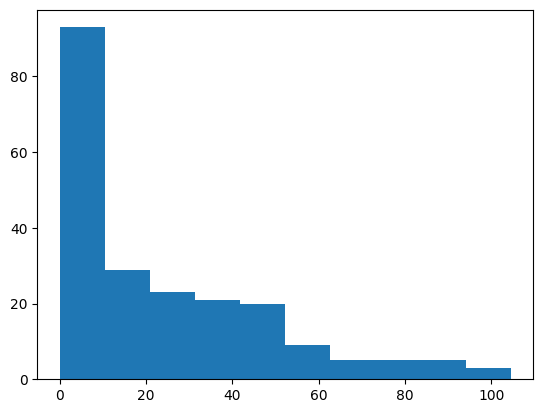

In [4]:
df = pd.read_csv("../tp3/out/csv/pool_y42.00_i4.csv")
simulation_data = get_simulation_data(df)

# 1.2 distribucion
plt.hist(simulation_data['event_times'], bins=10 )

# 1.2 tiempo medio y frecuencia media
print(f"Tiempo medio entre eventos: {simulation_data['avg_time_between_events']}")
print(f"Frecuencia media entre eventos: {simulation_data['avg_event_frequency']}")

[  0.         0.534273   0.534419   0.534446   0.534508   0.534671
   0.534751   0.534799   0.535156   0.535516   0.53568    0.53697
   0.537271   0.539149   0.539581   0.540261   0.541482   0.541912
   0.543107   0.543244   0.629081   0.734704   0.752775   0.951504
   0.971164   1.019522   1.402454   1.496863   2.126861   2.198715
   3.849961   3.917026   4.118689   5.31318    5.515055   5.657343
   7.045481   7.075874   7.152085   7.942044   8.499499   8.773377
   9.508262   9.568746  11.685818  13.956621  13.982213  14.071867
  14.081873  14.213664  14.451039  14.622117  14.872137  15.518616
  15.904634  16.010085  16.296894  17.233332  17.649396  17.986605
  18.75956   19.158527  19.234095  19.443903  20.244054  20.715883
  20.925318  21.082208  21.108589  21.116705  21.175972  21.351959
  21.519027  22.511572  23.646586  23.840381  24.175364  24.443645
  25.460679  26.158865  26.260337  26.736374  26.842421  26.991776
  27.23003   27.813397  28.099322  28.179486  29.217788  29.759

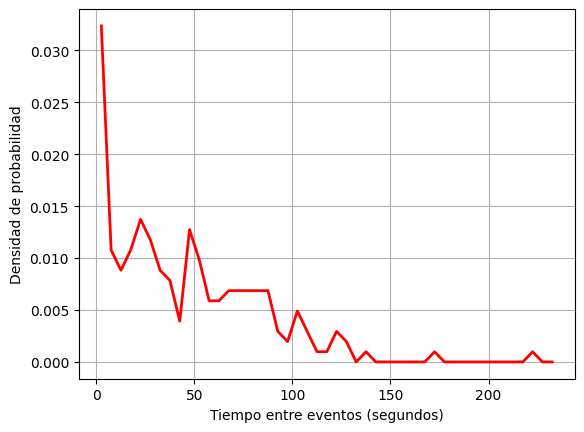

In [11]:
df = pd.read_csv("../tp3/out/csv/pool_y56.00_i4.csv")
simulation_data = get_simulation_data(df)

data = simulation_data['event_times']
print(data) 

bins_width = 5
bins = list(np.arange(min(data), max(data), 5))

# Histograma
# density=True devuelve puntos de la pdf. 
n, bins, patches = plt.hist(data, bins=bins, density=True, alpha=0.75)
plt.clf()

x_axis = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]

# Graficar PDF
plt.plot(x_axis, n, 'r', linewidth=2)

esperanza = sum(x_axis*n*bins_width)
print("La esperanza es: " + str(esperanza))

plt.xlabel('Tiempo entre eventos (segundos)')
plt.ylabel('Densidad de probabilidad')
plt.grid(True)

plt.show()






In [113]:
    bins_width = 2**(-8)
    
    path = r'/home/shadad/Desktop/tp2pod/simulacion-de-sistemas/tp3/out/csv'
    lista = ['42.00', '43.75', '45.50', '47.25', '49.00', '50.00', '50.75', '52.50', '54.25', '56.00']
    esperanzas = []
    for position in ['42.00']:
        regex = '*y'+ position+'_i*.csv'
        files = Path(path).glob(regex)
        dfs = [pd.read_csv(f) for f in files]
        df = pd.concat(dfs)
        simulation_data = get_simulation_data(df)
        data = simulation_data['time_between_events']
        bins = list(np.arange(min(data), .1, bins_width))

        # Histograma
        # density=True devuelve puntos de la pdf. 
        n, bins, patches = plt.hist(data, bins=bins, density=True, alpha=0.75)
        plt.clf()

        # x_axis = [(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)]
        
        # Graficar PDF
        
        x_axis = [bins[i] for i in range(len(bins)-1)]
        plt.plot(x_axis, n, 'r', linewidth=2)
        
        # formatter = ticker.ScalarFormatter(useMathText=True)
        # formatter.set_scientific(True)
        # formatter.set_powerlimits((-2,2))
        # plt.gca().xaxis.set_major_formatter(formatter)
        # plt.tick_params(axis='x', pad=15)
        # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0), useMathText=True)

        # Configurar ticks en el eje y
#         labels_x = []
#         for tick in x_axis[0:len(x_axis):10]:
#             label = '{:.2e}'.format(tick)
#             labels_x.append(label)

#         plt.xticks(x_axis, labels_x)
                
        plt.xlabel('Tiempo entre eventos (segundos)')
        plt.ylabel('Densidad de probabilidad')
        plt.grid(True)

        plt.savefig("20PDF_y"+position+".png")
        plt.clf()
    
    print(esperanzas)
    # plt.plot(lista,esperanzas,'o')
    plt.show()
        
    
    
    
    

[]


<Figure size 640x480 with 0 Axes>